In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms, datasets
import time

In [2]:
import pandas as pd
import numpy as np
import cv2
data_1 = pd.read_csv("naocuzchuli1.csv",sep=",", engine='python', encoding='utf-8')
data = pd.read_csv("数据标注.csv",sep=",", engine='python', encoding='utf-8')

In [3]:
data

,姓名,ID,Lable
0,吴华好,MR201802210163-Wu HuaHao,1
1,梁郁庆,MR201706120215-LiangYuQing,1
2,梁其盼,MR201602290243-Liang QiPan,1
3,黄甜弟,MR201803090487-HuangTianDi,1
4,黄江泉,MR201710230147-HuangJiangQuan,1
...,...,...,...
187,林振洪,MR201804230415-LinZhenHong,0
188,王陵,MR201804130045-WangLing,0
189,林秀容,MR201804200221-LinXiuRong,0
190,温景成,MR201804210230-WenJingCheng,0


In [4]:
all_names = []
path_label=[]
for h in range(0,len(data["ID"])):
    file_dir=data["ID"][h]
    print(file_dir)
    all_names.append(file_dir)
    path_label.append(data["Lable"][h])

MR201802210163-Wu HuaHao
MR201706120215-LiangYuQing
MR201602290243-Liang QiPan
MR201803090487-HuangTianDi
MR201710230147-HuangJiangQuan
MR2017062901390-LinGen You
MR201707060266-ChenGuiYing
MR201806250211-HuangHuiZhong
MR201806040279-Li JinRong
MR202103160080-Chen LianDing
MR201807080094-He Zhong
MR201708080222-Li GuiFeng
MR202109160378-Liang YouDi
MR201802200016-ZhaoDongSheng
MR201803140073-Fang LiChang
MR201711160167-Huang ZhiRong
MR201709170104-LiangSuZhen
MR202110280279-Yang XiTian
MR201803170300-Huang GenFa
MR201805060354-XieShengYu
MR201812090066-Lin Nong
MR201810030079-Huang QiDing
MR201806070184-ZhouLiBo
MR201811040118-Pan YiYou
MR202204270343-Huang BingQiang
MR201807130152-Zhang SheXie
MR201901140071-Xiao BaoXi
MR202007040281-Yin CaiDi
MR201907170393-Ou FuTai
MR201808280243-Lin ShiMei
MR201808150286-Huang ZhengLian
MR201902140144-Zhou RuiQiu
MR201905270177-Lu SongMao
MR201908300389-Huang YanChun
MR201909240217-Huang XianYou
MR201809280461-Huang GuiPing
MR201908140375-Huang Shu

In [5]:
np.array(path_label)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
all_X_list = all_names                  # all video file names
all_y_list = np.array(path_label)

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle

In [8]:
action_name_path = './UCF101actions.pkl'
save_model_path = "./ResNetCRNN_ckpt/"
data_path = "../data" 

In [9]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512   # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.0       # dropout probability

In [10]:
# DecoderRNN architecture
RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 256

# training parameters
k = 2             # number of target category
epochs = 5       # training epochs
batch_size = 144   #这要设置成和训练数据集一样的常度
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 18, 1

In [11]:
import torch
from torch import nn
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
def normalize_list(lst):
    np_list = np.array(lst)
    normalized_list = (np_list - np_list.min()) / (np_list.max() - np_list.min()) + 1
    return normalized_list.tolist()
def L1_tensor(x_feature):
    for i in range(0, len(x_feature)):
        #print(x_feature[i].shape)
        list_1 = []
        ls = x_feature[i]
        for j in ls:
            cc = np.sum(j)
            cc = abs(cc)
            list_1.append(cc)
            # print(cc)
        list_2 = normalize_list(list_1)
        # print(list_2)
        for k in range(0, len(x_feature[i])):
            x_feature[i][k] = x_feature[i][k] * list_2[k]
    return  x_feature
if torch.cuda.is_available():
    transformer_encoder = transformer_encoder.to('cuda')
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()       
        src = cnn_encoder(X)
        out = transformer_encoder(src)
        x_f = out.cpu().data.numpy()
        x_f = L1_tensor(x_f)
        x_f = torch.FloatTensor(x_f)
        out_1 = x_f.to('cuda')
        #print(out_1.shape)
        #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
        output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)
        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores,hidden


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            src = cnn_encoder(X)
            out = transformer_encoder(src)
            x_f = out.cpu().data.numpy()
            x_f = L1_tensor(x_f)
            x_f = torch.FloatTensor(x_f)
            out_1 = x_f.to('cuda')
            #print(out.shape)
            #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
            output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)

            #output,hidden = rnn_decoder(cnn_encoder(X))

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(cnn_encoder.state_dict(), os.path.join(save_model_path, 'cnn_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(rnn_decoder.state_dict(), os.path.join(save_model_path, 'rnn_decoder_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    y_tru = all_y.cpu().data.squeeze().numpy()
    y_pre = all_y_pred.cpu().data.squeeze().numpy()
    return test_loss, test_score,hidden,y_tru,y_pre

In [12]:
def train_2(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()
        src = cnn_encoder(X)
        out = transformer_encoder(src)
        x_f = out.cpu().data.numpy()
        x_f = L1_tensor(x_f)
        x_f = torch.FloatTensor(x_f)
        out_1 = x_f.to('cuda')
        #print(out_1.shape)
        #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
        output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)
        #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores,hidden


def validation_2(model, device, optimizer, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            src = cnn_encoder(X)
            out = transformer_encoder(src)
            x_f = out.cpu().data.numpy()
            x_f = L1_tensor(x_f)
            x_f = torch.FloatTensor(x_f)
            out_1 = x_f.to('cuda')
            #print(out_1.shape)
            #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
            output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)

            #output,hidden = rnn_decoder(cnn_encoder(X))

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    
    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(cnn_encoder.state_dict(), os.path.join(save_model_path, 'cnn_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(rnn_decoder.state_dict(), os.path.join(save_model_path, 'rnn_decoder_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))
    y_tru = all_y.cpu().data.squeeze().numpy()
    y_pre = all_y_pred.cpu().data.squeeze().numpy()
    return test_loss, test_score,hidden,y_tru,y_pre

In [13]:
def train_3(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()
        src = cnn_encoder(X)
        out = transformer_encoder(src)
        x_f = out.cpu().data.numpy()
        x_f = L1_tensor(x_f)
        x_f = torch.FloatTensor(x_f)
        out_1 = x_f.to('cuda')
        #print(out_1.shape)
        #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
        output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)
        #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores,hidden


def validation_3(model, device, optimizer, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            src = cnn_encoder(X)
            out = transformer_encoder(src)
            x_f = out.cpu().data.numpy()
            x_f = L1_tensor(x_f)
            x_f = torch.FloatTensor(x_f)
            out_1 = x_f.to('cuda')
            #print(out_1.shape)
            #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
            output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)

            #output,hidden = rnn_decoder(cnn_encoder(X))

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(cnn_encoder.state_dict(), os.path.join(save_model_path, 'cnn_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(rnn_decoder.state_dict(), os.path.join(save_model_path, 'rnn_decoder_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    y_tru = all_y.cpu().data.squeeze().numpy()
    y_pre = all_y_pred.cpu().data.squeeze().numpy()
    return test_loss, test_score,hidden,y_tru,y_pre

In [14]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} if use_cuda else {'batch_size': batch_size}



In [15]:
# train, test split
train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.25, random_state=42)

transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

train_set, valid_set = Dataset_CRNN(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_CRNN(data_path, test_list, test_label, selected_frames, transform=transform)

train_set_2, valid_set_2 = Dataset_CRNN_2(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_CRNN_2(data_path, test_list, test_label, selected_frames, transform=transform)

train_set_3, valid_set_3 = Dataset_CRNN_3(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_CRNN_3(data_path, test_list, test_label, selected_frames, transform=transform)

train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

train_loader_2 = data.DataLoader(train_set_2, **params)
valid_loader_2 = data.DataLoader(valid_set_2, **params)

train_loader_3 = data.DataLoader(train_set_3, **params)
valid_loader_3 = data.DataLoader(valid_set_3, **params)

In [16]:
# Create model
cnn_encoder = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)

cnn_encoder_2 = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder_2 = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)

cnn_encoder_3 = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder_3 = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)
# Parallelize model to multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn_encoder = nn.DataParallel(cnn_encoder)
    rnn_decoder = nn.DataParallel(rnn_decoder)

    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = list(cnn_encoder.module.fc1.parameters()) + list(cnn_encoder.module.bn1.parameters()) + \
                  list(cnn_encoder.module.fc2.parameters()) + list(cnn_encoder.module.bn2.parameters()) + \
                  list(cnn_encoder.module.fc3.parameters()) + list(rnn_decoder.parameters())

elif torch.cuda.device_count() == 1:
    print("Using", torch.cuda.device_count(), "GPU!")
    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
                  list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
                  list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters())
    crnn_params_2 = list(cnn_encoder_2.fc1.parameters()) + list(cnn_encoder_2.bn1.parameters()) + \
                  list(cnn_encoder_2.fc2.parameters()) + list(cnn_encoder_2.bn2.parameters()) + \
                  list(cnn_encoder_2.fc3.parameters()) + list(cnn_encoder_2.parameters())
    crnn_params_3 = list(cnn_encoder_3.fc1.parameters()) + list(cnn_encoder_3.bn1.parameters()) + \
                  list(cnn_encoder_3.fc2.parameters()) + list(cnn_encoder_3.bn2.parameters()) + \
                  list(cnn_encoder_3.fc3.parameters()) + list(cnn_encoder_3.parameters())
elif torch.cuda.device_count() == 0:
    print("Using", torch.cuda.device_count(), "CPU!")
    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
                  list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
                  list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters())
    crnn_params_2 = list(cnn_encoder_2.fc1.parameters()) + list(cnn_encoder_2.bn1.parameters()) + \
                  list(cnn_encoder_2.fc2.parameters()) + list(cnn_encoder_2.bn2.parameters()) + \
                  list(cnn_encoder_2.fc3.parameters()) + list(cnn_encoder_2.parameters())
    crnn_params_3 = list(cnn_encoder_3.fc1.parameters()) + list(cnn_encoder_3.bn1.parameters()) + \
                  list(cnn_encoder_3.fc2.parameters()) + list(cnn_encoder_3.bn2.parameters()) + \
                  list(cnn_encoder_3.fc3.parameters()) + list(cnn_encoder_3.parameters())

optimizer = torch.optim.Adam(crnn_params, lr=learning_rate)
optimizer_2 = torch.optim.Adam(crnn_params_2, lr=learning_rate)
optimizer_3 = torch.optim.Adam(crnn_params_3, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

Using 1 GPU!


/root/miniconda3/lib/python3.8/site-packages/torch/optim/adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [17]:
# start training
#torch.backends.cudnn.enabled = False
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores,hidden = train(log_interval, [cnn_encoder, rnn_decoder], device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score,thidden,y_tru,y_pre = validation([cnn_encoder, rnn_decoder], device, optimizer, valid_loader)
    
    train_losses_2, train_scores_2,hidden_2 = train_2(log_interval, [cnn_encoder_2, rnn_decoder_2], device, train_loader_2, optimizer_2, epoch)
    epoch_test_loss_2, epoch_test_score_2,thidden_2,y_tru_2,y_pre_2 = validation_2([cnn_encoder_2, rnn_decoder_2], device, optimizer_2, valid_loader_2)
    
    train_losses_3, train_scores_3,hidden_3 = train_3(log_interval, [cnn_encoder_3, rnn_decoder_3], device, train_loader_3, optimizer_3, epoch)
    epoch_test_loss_3, epoch_test_score_3,thidden_3,y_tru_3,y_pre_3 = validation_3([cnn_encoder_3, rnn_decoder_3], device, optimizer_3, valid_loader_3)

    # save results
    '''
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    # save all train test results
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./CRNN_epoch_training_losses.npy', A)
    np.save('./CRNN_epoch_training_scores.npy', B)
    np.save('./CRNN_epoch_test_loss.npy', C)
    np.save('./CRNN_epoch_test_score.npy', D)
    '''


Test set (48 samples): Average loss: 0.6283, Accuracy: 72.92%

Epoch 1 model saved!

Test set (48 samples): Average loss: 0.7134, Accuracy: 27.08%

Epoch 1 model saved!

Test set (48 samples): Average loss: 0.6882, Accuracy: 72.92%

Epoch 1 model saved!

Test set (48 samples): Average loss: 0.4992, Accuracy: 72.92%

Epoch 2 model saved!

Test set (48 samples): Average loss: 0.7136, Accuracy: 27.08%

Epoch 2 model saved!

Test set (48 samples): Average loss: 0.6889, Accuracy: 72.92%

Epoch 2 model saved!

Test set (48 samples): Average loss: 0.7213, Accuracy: 29.17%

Epoch 3 model saved!

Test set (48 samples): Average loss: 0.7135, Accuracy: 27.08%

Epoch 3 model saved!

Test set (48 samples): Average loss: 0.6884, Accuracy: 72.92%

Epoch 3 model saved!

Test set (48 samples): Average loss: 0.1011, Accuracy: 100.00%

Epoch 4 model saved!

Test set (48 samples): Average loss: 0.7135, Accuracy: 27.08%

Epoch 4 model saved!

Test set (48 samples): Average loss: 0.6878, Accuracy: 72.92%



In [18]:
loss_fin = [train_losses[0],train_losses_2[0],train_losses_3[0]]
def normalize_array(arr, range_min, range_max):
    arr_min, arr_max = min(arr), max(arr)
    ar = [((x - arr_min) / (arr_max - arr_min)) * (range_max - range_min) + range_min for x in arr]
    for i in range(0,len(ar)):
        ar[i] = (range_max+1) - ar[i]
    return ar
import numpy as np
loss_fin = normalize_array(loss_fin, 1, 1.5)
loss_fin

[1.5, 1.0, 1.016372134208916]

In [19]:
y_tru=pd.DataFrame(y_tru)
y_pre=pd.DataFrame(y_pre)
y_tru.to_csv("y_tru_1.csv")
y_pre.to_csv("y_pre_1.csv")
y_tru=pd.DataFrame(y_tru_2)
y_pre=pd.DataFrame(y_pre_2)
y_tru.to_csv("y_tru_2.csv")
y_pre.to_csv("y_pre_2.csv")
y_tru=pd.DataFrame(y_tru_3)
y_pre=pd.DataFrame(y_pre_3)
y_tru.to_csv("y_tru_3.csv")
y_pre.to_csv("y_pre_3.csv")

In [20]:
def weight(hidden,we):
    for i in range(0,len(hidden)):
        hidden[i] = hidden[i]*we
    return hidden
hidden_1 = hidden.cpu().detach().numpy()
hidden_1 = weight(hidden_1,loss_fin[0])
hidden_2 = hidden_2.cpu().detach().numpy()
hidden_2 = weight(hidden_2,loss_fin[1])
hidden_3 = hidden_3.cpu().detach().numpy()
hidden_3 = weight(hidden_3,loss_fin[2])
thidden1 = thidden.cpu().detach().numpy()
thidden1 = weight(thidden1,loss_fin[0])
thidden2 = thidden_2.cpu().detach().numpy()
thidden2 = weight(thidden2,loss_fin[1])
thidden3 = thidden_3.cpu().detach().numpy()
thidden3 = weight(thidden3,loss_fin[2])

In [21]:
train_fin = np.concatenate((hidden_1, hidden_2), axis=1)
train_fin = np.concatenate((train_fin, hidden_3), axis=1)
test_fin = np.concatenate((thidden1, thidden2), axis=1)
test_fin = np.concatenate((test_fin, thidden3), axis=1)

In [22]:
train_fin.shape[1]

768

In [23]:
def acc(y_pred,y_train):
    n= 0
    y =  y_pred.cpu().detach().numpy()
    for i in range(0,len(y_pred)):
        if(y[i][0]>0.5):
            a = 0
        else:
            a = 1
        if(a == y_train[i]):
            n = n+1
    print(n/len(y_pred))
    a = n/len(y_pred)
    return a

In [24]:
y_pre

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split #引入训练集、测试集划分函数
import torch 
import torch.nn.functional as Fun
class bpnnModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(bpnnModel, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 定义隐藏层网络
        self.hidden1 = torch.nn.Linear(n_hidden, 200)   # 定义隐藏层网络
        self.bn = torch.nn.BatchNorm1d(200)
        self.out = torch.nn.Linear(200, n_output)   # 定义输出层网络
    def forward(self, x):
        x = Fun.relu(self.hidden(x))        # 隐藏层的激活函数,采用relu,也可以采用sigmod,tanh
        x = Fun.relu(self.hidden1(x))
        x = self.bn(x)
        out = Fun.softmax(self.out(x), dim=1) # 输出层softmax激活函数
        return out



In [26]:
lr        = 0.001 #学习率
epochs    = 2000    
n_feature = train_fin.shape[1]    # 输入特征
n_hidden  = 150   # 隐含层
n_output  = 2    # 输出
net = bpnnModel(n_feature=n_feature, n_hidden=n_hidden, n_output=n_output)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 优化器选用随机梯度下降方式
loss_func = torch.nn.CrossEntropyLoss() # 对于多分类一般采用的交叉熵损失函数
#loss_func = torch.nn.NLLLoss() # 对于多分类一般采用的交叉熵损失函数

In [27]:
x_train = torch.FloatTensor(train_fin)
y_train = torch.LongTensor(train_label)
x_test = torch.FloatTensor(test_fin)
y_test = torch.LongTensor(test_label)

In [28]:
loss_l = []
ac = []
loss_steps     = np.zeros(epochs)  # 保存每一轮epoch的损失函数值
accuracy_steps = np.zeros(epochs)  # 保存每一轮epoch的在测试集上的精度
for epoch in range(epochs):
    y_pred = net(x_train)             # 前向过程
    #print(y_pred)
    loss = loss_func(y_pred, y_train) # 输出与label对比
    loss_l.append(loss.cuda().data.cpu().detach().numpy())
    optimizer.zero_grad()             # 梯度清零
    loss.backward()                   # 反向传播
    optimizer.step()                  # 使用梯度优化器
    loss_steps[epoch] = loss.item()   # 保存loss
    a = acc(y_pred, y_train)
    print(a)
    ac.append(a)
# 下面计算测试机的精度，不需要求梯度
with torch.no_grad():             
        y_pred  = net(x_test) # 测试集预测
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_steps[epoch] = correct.mean()  # 测试集精度
print("测试预测准确率",accuracy_steps[-1])
#ac.to_csv("ac.csv")

0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


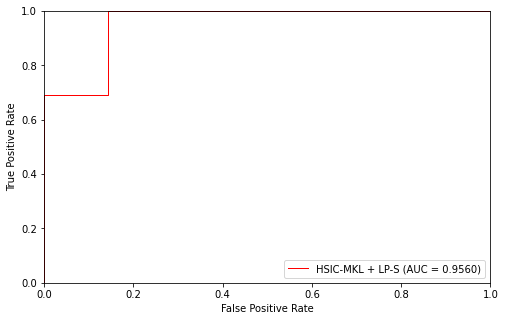

In [64]:
# 1.导入相关包
import matplotlib.pyplot as plt
import random
# 2.数据处理部分
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
y_p = torch.argmax(y_pred, dim=1).cuda().data.cpu().detach().numpy()
y_p = y_p.astype(float)
for i in range(0,10):
    if(y_p[i]>0.5):
        a = random.uniform(0, 1)
        y_p[i]=y_p[i]-a
    else:
        a = random.uniform(0, 1)
        y_p[i]=y_p[i]+a
        #print(y_p[i])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test, y_p)  # 计算FPR和TPR
auc_1 = auc(fpr_1, tpr_1)  # 计算AUC值
# precision_1, recall_1, threshold_1 = precision_recall_curve(y_1, yp_1)  # 计算Precision和Recall
# aupr_1 = auc(recall_1, precision_1)  # 计算AUPR值
# precision_2, recall_2, threshold_2 = precision_recall_curve(y_2, yp_2)  # 计算Precision和Recall
# aupr_2 = auc(recall_2, precision_2)  # 计算AUPR值
# precision_3, recall_3, threshold_3 = precision_recall_curve(y_3, yp_3)  # 计算Precision和Recall
# aupr_3 = auc(recall_3, precision_3)  # 计算AUPR值
# precision_4, recall_4, threshold_4 = precision_recall_curve(y_4, yp_4)  # 计算Precision和Recall
# aupr_4 = auc(recall_4, precision_4)  # 计算AUPR值


# 3.绘制曲线
line_width = 1  # 曲线的宽度
plt.figure(figsize=(8, 5))  # 图的大小

plt.plot(fpr_1, tpr_1, lw=line_width, label='HSIC-MKL + LP-S (AUC = %0.4f)' % auc_1, color='red')

# plt.plot(precision_3, recall_3, lw=line_width, label='HSIC-MKL + LP-S (AUPR = %0.4f)' % aupr_3, color='red')
# plt.plot(precision_1, recall_1, lw=line_width, label='HSIC-MKL + LP-P (AUPR = %0.4f)' % aupr_1, color='blue')
# plt.plot(precision_4, recall_4, lw=line_width, label='Mean weighted + LP-S (AUPR = %0.4f)' % aupr_4, color='green')
# plt.plot(precision_2, recall_2, lw=line_width, label='Mean weighted + LP-P (AUPR = %0.4f)' % aupr_2, color='orange')


# 4.坐标轴范围和标题
plt.xlim([0.0, 1.0])  # 限定x轴的范围
plt.ylim([0.0, 1.0])  # 限定y轴的范围
# plt.xticks(range(0, 10, 1)) # 修改x轴的刻度
# plt.yticks(range(0, 10, 1)) # 修改y轴的刻度

plt.xlabel('False Positive Rate')  # x坐标轴标题
plt.ylabel('True Positive Rate')  # y坐标轴标题
# plt.xlabel('Recall')
# plt.ylabel('Precision')

# plt.title('Receiver Operating Characteristic')  # 图标题

#plt.grid()  # 在图中添加网格

plt.legend(loc="lower right")  # 显示图例并指定图例位置


# 5.中文处理问题
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False


# 6.展示图片和保存
plt.savefig('AUC.tif', dpi=300)
plt.show()

In [65]:
#y_test=pd.DataFrame(y_test)
#y_p=pd.DataFrame(y_p)
#y_test.to_csv("CRNN_y_test.csv")
#y_p.to_csv("CRNN-pre.csv")

In [66]:
#loss_l = pd.DataFrame(loss_l)
#loss_l.to_csv("loss_1.csv")

In [67]:
#y_pre

In [68]:
n = 0
for i in range(0,len(y_p)):
    n = n+1
    if(y_p[i] >= 0.5):
        y_p[i] = 1
    else:
        y_p[i] = 0
from sklearn.metrics import classification_report
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        35
           1       0.69      0.69      0.69        13

    accuracy                           0.83        48
   macro avg       0.79      0.79      0.79        48
weighted avg       0.83      0.83      0.83        48



In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_tru, y_pre))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.27      1.00      0.43        13

    accuracy                           0.27        48
   macro avg       0.14      0.50      0.21        48
weighted avg       0.07      0.27      0.12        48



/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
X = []
path = "../data" 
selected_folder = "MR201802210163-Wu HuaHao"
#print(path)
for i in range(1,20,1):
    file_dir=path+"/"+selected_folder
    name = os.listdir(file_dir)
    for j in range(0,len(name)):
        #print(name[i][0])
        if(name[j][0] == '2' and name[j][1] == '-'):
            for k in range(0,len(name)):
                if(name[i][0] == '3' and name[i][1] == '-'):
                    file_dir1 = file_dir+"/"+name[k]
                    break
            break
        else:
            if(name[j][0] == '5'and name[j][1] == '-'):
                for k in range(0,len(name)):
                    if(name[k][0] == '6' and name[k][1] == '-'):
                        file_dir1 = file_dir+"/"+name[k]
                        break
                break
            else:
                if(name[j][0] == '6'and name[j][1] == '-'):
                    for k in range(0,len(name)):
                        if(name[k][0] == '7' and name[k][1] == '-'):
                            file_dir1 = file_dir+"/"+name[k]
                            break
                    break
                else:
                    if(name[j][0] == '3'and name[j][1] == '-'):
                        for k in range(0,len(name)):
                            if(name[k][0] == '4' and name[k][1] == '-'):
                                file_dir1 = file_dir+"/"+name[k]
                                break
                        break
                    else:
                        if(name[j][0] == '9'and name[j][1] == '-'):
                            for k in range(0,len(name)):
                                if(name[k][0] == '1' and name[k][1] == '0'):
                                    file_dir1 = file_dir+"/"+name[k]
                                    break
                            break
    #print(file_dir1)
    name_1 = os.listdir(file_dir1)
    print(i)
    if(name_1[i] != ".ipynb_checkpoints"):
        if(name_1[i] != "Thumbs.db"):
            character_address = file_dir1+"/"+name_1[i]
    print(character_address)

1
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_400.JPG
2
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_402.JPG
3
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_394.JPG
4
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_403.JPG
5
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_385.JPG
6
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_396.JPG
7
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_390.JPG
8
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_397.JPG
9
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_388.JPG
10
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_387.JPG
11
../data/MR201802210163-Wu HuaHao/101-20220517144717/MR201802210163-Wu HuaHao_392.JPG
12
../data/MR201802210163-Wu HuaHao/101-2

In [19]:
src = torch.rand(144, 17, 512)

In [22]:
src[0].shape

torch.Size([17, 512])